# EDA

First, I did EDA to explore the structure of image meta data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Libraries

In [ ]:
import os, sys
import pandas as pd
import numpy as np
import time, datetime

import xgboost as xgb
import seaborn as sns
from tqdm.notebook import tqdm
from PIL import Image
import cv2
from joblib import Parallel, delayed
import psutil
import hashlib;

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score, confusion_matrix

sns.set(rc={'figure.figsize': (11.7, 8.27)})
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Load the train data

In [ ]:
train_label=pd.read_csv('/content/gdrive/MyDrive/data/train.csv')
train_label['Id']= train_label['Id'].apply(lambda x: '/content/gdrive/MyDrive/data/train/train/'+str(x)+'.png')
enc=LabelEncoder()
enc.fit(['Connective','Cancer','Immune','Normal'])
img_label=enc.transform(train_label['Type'].values)
train_label['Type']=img_label

## Image Properties
Collect some summary statistics about the images:

- Height
- Width
- Height to Width Ratio
- Total Number of Pixels
- Total Number of Black Pixels
- Total Proportion of Black Pixels
- Channel Means

Use the cv2 to get the meta data

In [ ]:
train_results = []

for index, row in tqdm(train_label.iterrows(), total=train_label.shape[0]):
    img = cv2.imread(row['Id'])

    height, width, channels = img.shape
    ratio = width/height
    pixel_count = width*height
    gray_scaled = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    black_cnt = pixel_count-cv2.countNonZero(gray_scaled)
    black_pct = black_cnt/pixel_count
    mean0, mean1, mean2, _ = cv2.mean(img)

    observation = np.array(
        (row['Type'], height, width, ratio, pixel_count, black_cnt, black_pct, mean0, mean1, mean2))

    train_results.append(observation)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until




#### Chose the xgboost to analysis the meta features of the train images.

In [ ]:
train_results_df = pd.DataFrame(train_results)
train_results_df.columns = [
    'Type','height','width','ratio','pixel_count','black_cnt','black_pct','mean_c0','mean_c1','mean_c2']

In [ ]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'eta': 0.005,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'tree_method': 'gpu_hist',
    'num_class': 5}

In [ ]:
X = train_results_df.drop(columns=['Type'])
y = train_results_df['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100000,
    evals=watchlist,
    early_stopping_rounds=250,
    verbose_eval=100
)

[0]	train-mlogloss:1.60329	valid-mlogloss:1.60483
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 250 rounds.
[100]	train-mlogloss:1.15556	valid-mlogloss:1.29407
[200]	train-mlogloss:0.898889	valid-mlogloss:1.13535
[300]	train-mlogloss:0.732123	valid-mlogloss:1.05085
[400]	train-mlogloss:0.617633	valid-mlogloss:0.997366
[500]	train-mlogloss:0.535301	valid-mlogloss:0.970055
[600]	train-mlogloss:0.476564	valid-mlogloss:0.953204
[700]	train-mlogloss:0.432068	valid-mlogloss:0.947075
[800]	train-mlogloss:0.39765	valid-mlogloss:0.941458
[900]	train-mlogloss:0.374225	valid-mlogloss:0.940787
[1000]	train-mlogloss:0.35578	valid-mlogloss:0.944554
[1100]	train-mlogloss:0.34186	valid-mlogloss:0.9475
Stopping. Best iteration:
[886]	train-mlogloss:0.377207	valid-mlogloss:0.940419



#### cohen_kappa_score

In [ ]:
test_path = ['/content/gdrive/MyDrive/data/test/test/{0}.png'.format(x) for x in range(10001, 10401)]
test_label = pd.DataFrame(test_path)
test_label['Type']=0

In [ ]:
test_label['Id']=test_label.iloc[:,0]

In [ ]:
test_results = []
for index, row in tqdm(test_label.iterrows(), total=test_label.shape[0]):
    img = cv2.imread((row['Id']))

    height, width, channels = img.shape
    ratio = width/height
    pixel_count = width*height
    gray_scaled = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    black_cnt = pixel_count-cv2.countNonZero(gray_scaled)
    black_pct = black_cnt/pixel_count
    mean0, mean1, mean2, _ = cv2.mean(img)

    observation = np.array(
        (np.nan, height, width, ratio, pixel_count, black_cnt, black_pct, mean0, mean1, mean2))

    test_results.append(observation)

test_results_df = pd.DataFrame(test_results)
test_results_df.columns = [
    'Type','height','width','ratio','pixel_count','black_cnt','black_pct','mean_c0','mean_c1','mean_c2']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
pred = pd.DataFrame(np.argmax(bst.predict(dvalid), axis=1))
results = pd.concat([y_test.reset_index(drop=True), pred], axis=1)
score = cohen_kappa_score(results.iloc[:,0], results.iloc[:,1], weights="quadratic")

print('Validation Kappa:', score)

Validation Kappa: 0.42533267006591213


#### confusion_matrix

[Text(33.0, 0.5, 'True label'), Text(0.5, 15.0, 'Predicted label')]

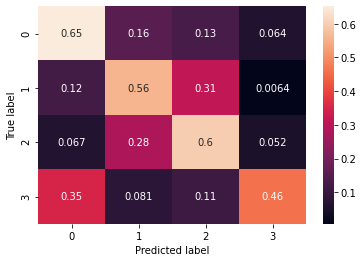

In [ ]:
cm = confusion_matrix(y_true=results.iloc[:,0], y_pred=results.iloc[:,1])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True)
ax.set(ylabel='True label', xlabel='Predicted label')

#### the distribution of image data

In [ ]:
train_label['Type'].value_counts()/train_label.shape[0]

2    0.332877
1    0.331507
0    0.249315
3    0.086301
Name: Type, dtype: float64

#### important features

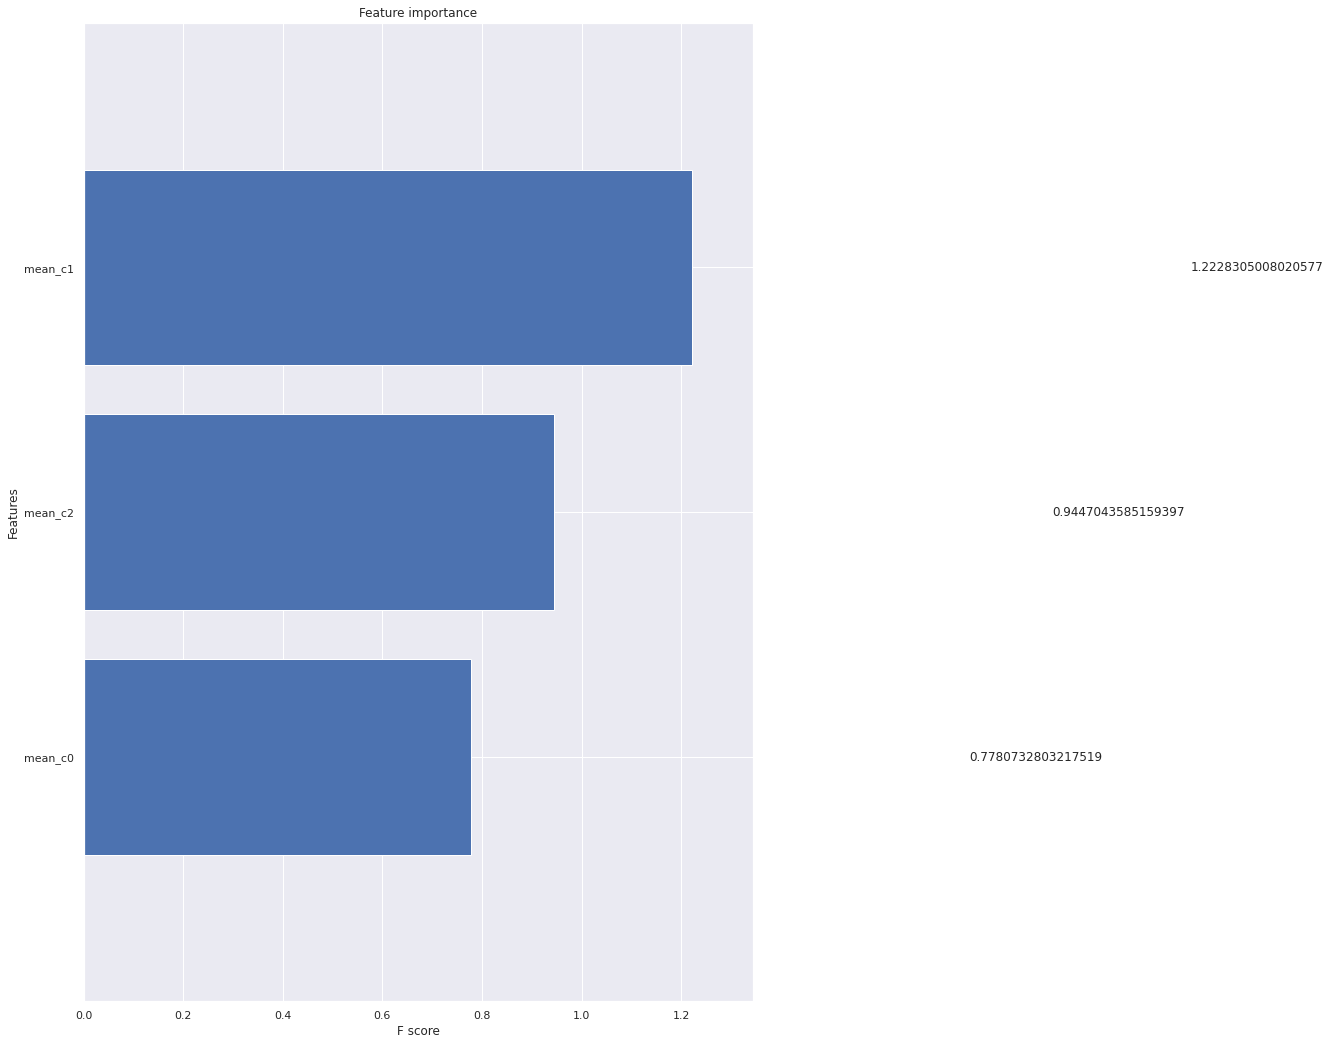

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, importance_type='gain', height=0.8, ax=ax)

#### make a submission file to find the relationship bewteen the trainset and test set

In [ ]:
test_label['num']=list(range(1,401))

In [ ]:
dtest = xgb.DMatrix(test_results_df.drop(columns=['Type']))
test_pred = pd.DataFrame(np.argmax(bst.predict(dtest), axis=1))
submission = pd.concat([test_label['num'], test_pred], axis=1)
submission.columns = ['Id','Type']
submission.to_csv('submission.csv', index=False)
submission.head()

,Id,Type
0,1,1
1,2,1
2,3,1
3,4,2
4,5,1


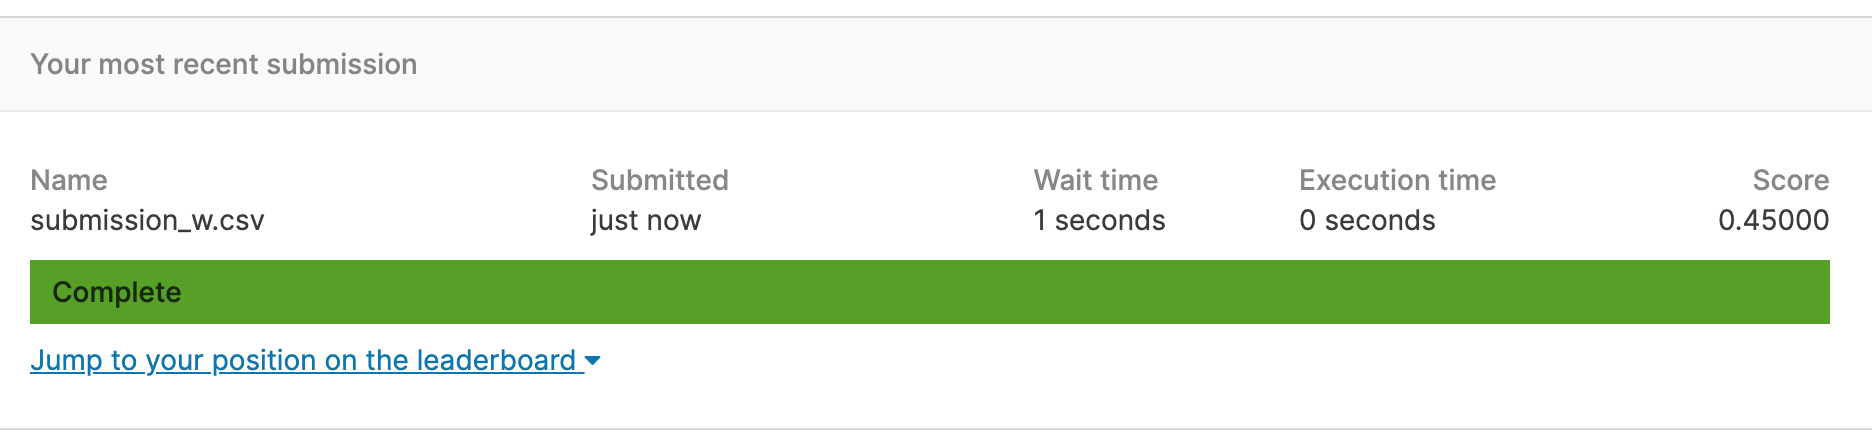

### Then, I want to explore if there are any duplicate pictures which may have bad negative on this case.

In [ ]:
def getImageMetaData(p):
    strFile = p
    file = None;
    bRet = False;
    strMd5 = "";
    
    try:
        file = open(strFile, "rb");
        md5 = hashlib.md5();
        strRead = "";
        
        while True:
            strRead = file.read(8096);
            if not strRead:
                break;
            md5.update(strRead);
        #read file finish
        bRet = True;
        strMd5 = md5.hexdigest();
    except:
        bRet = False;
    finally:
        if file:
            file.close()

    return p,strMd5

In [ ]:
img_meta_l = Parallel(n_jobs=psutil.cpu_count(), verbose=1)(
    (delayed(getImageMetaData)(fp) for fp in train_label['Id']))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   23.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   41.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 2190 out of 2190 | elapsed:  2.8min finished


In [ ]:
img_meta_df = pd.DataFrame(np.array(img_meta_l))
img_meta_df.columns = ['Id', 'strMd5']

In [ ]:
train_label = train_label.merge(img_meta_df,on='Id')

In [ ]:
train_label['strMd5_count'] = train_label.groupby('strMd5').Id.transform('count')

In [ ]:
train_label['strMd5_train_count'] = train_label['strMd5'].map(train_label.groupby('strMd5')['Type'].apply(lambda x:x.notnull().sum()))

In [ ]:
train_label['strMd5_nunique'] = train_label.groupby('strMd5')['Type'].transform('nunique').astype('int')

In [ ]:
train_label.to_csv('strMd5.csv',index=None)

### Fortunately, there are no duplicate pictures here

In [ ]:
train_label[train_label.strMd5_count>1].strMd5_count.value_counts()

Series([], Name: strMd5_count, dtype: int64)

In [ ]:
train_label[(train_label.strMd5_train_count>1)&(train_label.strMd5_nunique==1)].strMd5_count.value_counts()

Series([], Name: strMd5_count, dtype: int64)